In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
video = cv2.VideoCapture('../data/videos/TandemRun.mp4')

In [5]:
video.get(cv2.CAP_PROP_FRAME_COUNT) / video.get(cv2.CAP_PROP_FPS)

600.8335694552644

In [7]:
video.get(cv2.CAP_PROP_FRAME_HEIGHT)

2160.0

In [17]:
ret, frame = video.read()

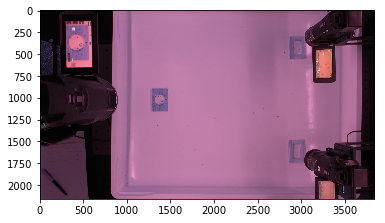

In [18]:
plt.imshow(frame)

In [134]:
frame.shape

(2160, 3840, 3)

In [116]:
xmin = 1470
xmax = 2840
ymin = 50
ymax = 2000

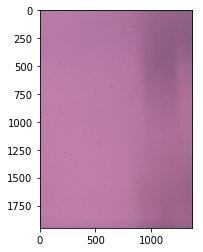

In [117]:
cropped = frame[ymin:ymax, xmin:xmax]
plt.imshow(cropped)

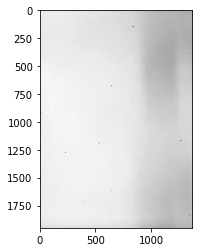

In [118]:
grayed = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
plt.imshow(grayed, 'gray')

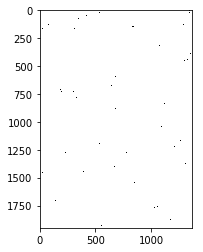

In [119]:
th = cv2.adaptiveThreshold(grayed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
plt.imshow(th, 'gray')

In [120]:
cv2.imwrite('th.png', th)
cv2.imwrite('cropped.png', cropped)

True

In [127]:
im2, cont, _ = cv2.findContours(th.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
M = map(cv2.moments, cont)
cxs = []
cys = []
MIN_CONT_SIZE = 45
for i, m in enumerate(M):
    if m['m00'] < MIN_CONT_SIZE:
        continue
    try:
        cx = int(m['m10']/m['m00'])
        cy = int(m['m01']/m['m00'])
        
        cxs.append(cx)
        cys.append(cy)
    except ZeroDivisionError:
        print('Centroid error for contour {}'.format(i))
        continue

In [128]:
len(cxs)

18

In [129]:
cropped_box = cropped.copy()
for cx, cy in zip(cxs, cys):
    cv2.rectangle(cropped_box, (cx-15, cy-15), (cx+15, cy+15), (0, 255, 0), 3)
cv2.imwrite('boxes.png', cropped_box)

True

In [132]:
i = 0
for cx, cy in zip(cxs, cys):
    i += 1
    if cx < 15 or cy < 15:
        continue
    windowed = grayed[cy-15:cy+15, cx-15:cx+15]
    ret, bw = cv2.threshold(windowed, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    _, cont, _ = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    if len(cont) ==0 or len(cont) > 2:
        cv2.imwrite('null{}.png'.format(i), windowed)
        continue
    
    masked = windowed * (bw == 0)
    cv2.imwrite('ants{}.png'.format(i), masked)
    